# BALANCING THE DATA

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the data
df = pd.read_csv('../data/cvss_data.csv', encoding='utf-8')
new_df = df[['english_description', 'cvssv3_attack_vector']]

# Prepare the data for SMOTE
# Convert text data to numerical using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limit features to 1000 most frequent terms
X = vectorizer.fit_transform(new_df['english_description'].astype(str))

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(new_df['cvssv3_attack_vector'])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Convert y_balanced back to original labels
y_balanced = le.inverse_transform(y_balanced)

# Convert X_balanced back to text descriptions using inverse_transform
# Since we can't directly convert TF-IDF back to text, we'll use nearest neighbors
from sklearn.neighbors import NearestNeighbors

# Find nearest neighbors for each synthetic point
nbrs = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(X)
indices = nbrs.kneighbors(X_balanced, return_distance=False)

# Get the corresponding descriptions
balanced_descriptions = new_df['english_description'].iloc[indices.ravel()].values

# Create balanced dataframe
balanced_df = pd.DataFrame({
    'english_description': balanced_descriptions,
    'cvssv3_attack_vector': y_balanced
})

# Export the balanced dataframe to a CSV file
output_file = 'balanced_cvss_data.csv'
balanced_df.to_csv(output_file, index=False)

# Show sample of the balanced data
print("Sample of balanced dataframe:")
print(balanced_df.head())
print("\
Shape of balanced dataframe:", balanced_df.shape)
print("\
Distribution of attack vectors in balanced data:")
print(balanced_df['cvssv3_attack_vector'].value_counts())

C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_44044\3099881500.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=original_df, x='cvssv3_attack_vector', ax=ax1, palette='viridis')
C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_44044\3099881500.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='cvssv3_attack_vector', ax=ax2, palette='viridis')


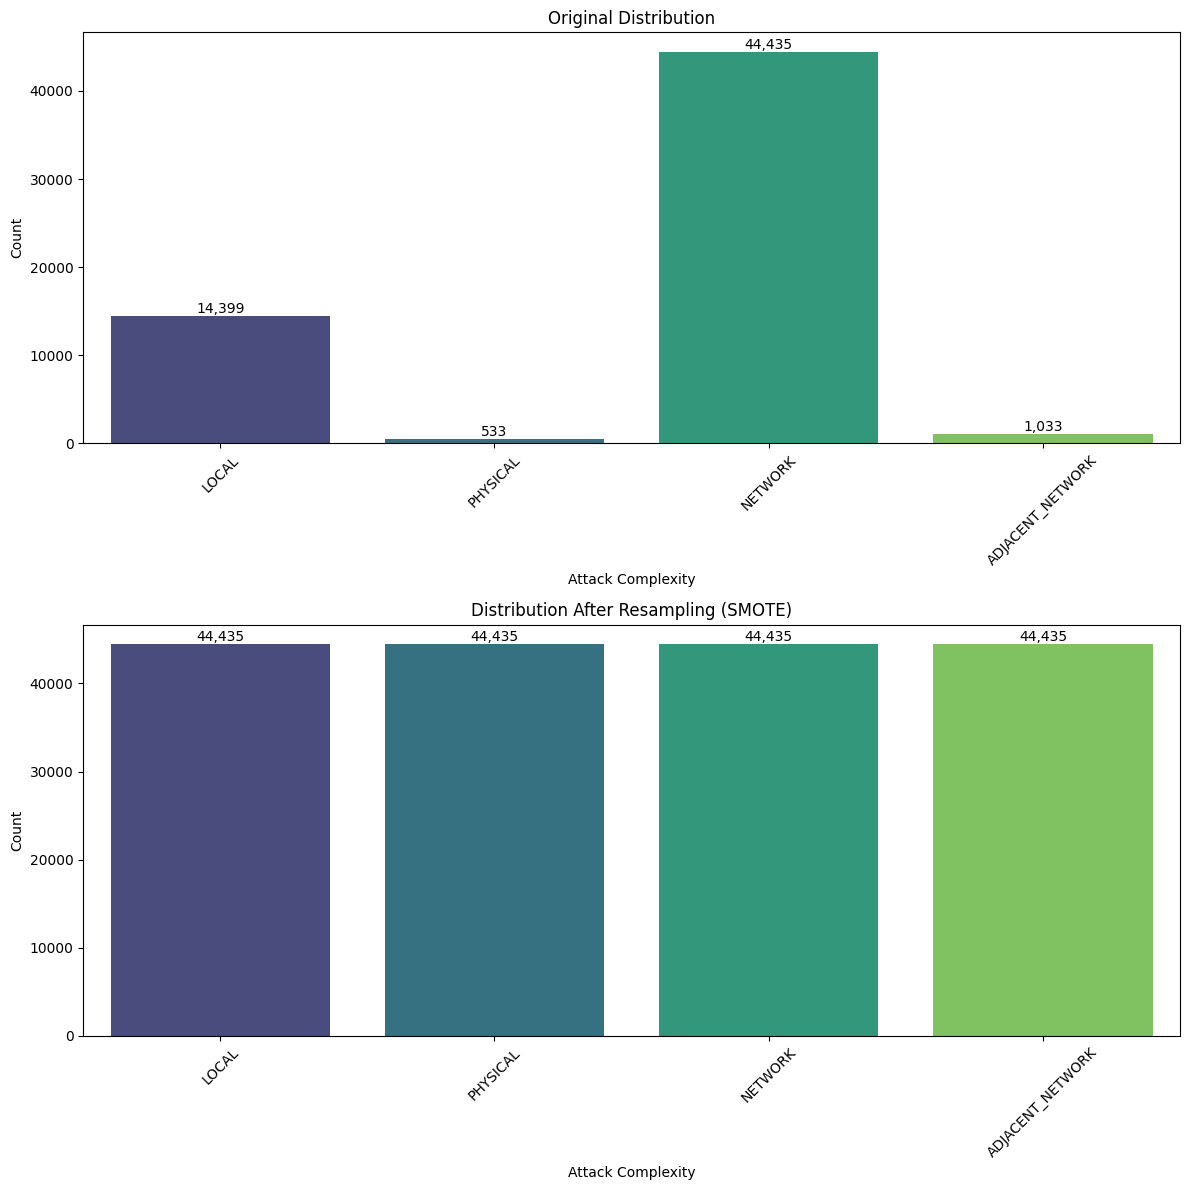

Original Distribution:
cvssv3_attack_vector
NETWORK             44435
LOCAL               14399
ADJACENT_NETWORK     1033
PHYSICAL              533
Name: count, dtype: int64

Balanced Distribution:
cvssv3_attack_vector
LOCAL               44435
PHYSICAL            44435
NETWORK             44435
ADJACENT_NETWORK    44435
Name: count, dtype: int64


In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read original data
original_df = pd.read_csv('../data/cvss_data.csv')
original_df = original_df[['cvssv3_attack_vector']]

# Read balanced data
balanced_df = pd.read_csv('./balanced_cvss_data.csv')

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot original distribution
sns.countplot(data=original_df, x='cvssv3_attack_vector', ax=ax1, palette='viridis')
ax1.set_title('Original Distribution')
ax1.set_xlabel('Attack Complexity')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars for original data
for p in ax1.patches:
    ax1.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

# Plot balanced distribution
sns.countplot(data=balanced_df, x='cvssv3_attack_vector', ax=ax2, palette='viridis')
ax2.set_title('Distribution After Resampling (SMOTE)')
ax2.set_xlabel('Attack Complexity')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars for balanced data
for p in ax2.patches:
    ax2.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

plt.tight_layout()
plt.show()

# Print the exact counts for original and balanced data
print("Original Distribution:")
print(original_df['cvssv3_attack_vector'].value_counts())

print("\nBalanced Distribution:")
print(balanced_df['cvssv3_attack_vector'].value_counts())

# GENERATE TRAIN AND TEST DATASET

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('./balanced_cvss_data.csv')

print(data.shape)
data.info()

(177740, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177740 entries, 0 to 177739
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   english_description   177740 non-null  object
 1   cvssv3_attack_vector  177740 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [2]:
for col_name in list(data.columns.values[0:9]):
    print(col_name)
    print( data[col_name].value_counts(dropna=False) )
    print("")

english_description
english_description
"Windows Mobile Broadband Driver Remote Code Execution Vulnerability"                                                                                                                                                                                                                                                                                  1494
"Secure Boot Security Feature Bypass Vulnerability"                                                                                                                                                                                                                                                                                                     995
"io_uring UAF, Unix SCM garbage collection"                                                                                                                                                                                                                             

In [3]:
pd.set_option('display.max_colwidth', None)
print(data.loc[data['english_description'].str.split().apply(len) < 10]['english_description'].shape)
desc_len = data['english_description'].str.split().apply(len)


def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

desc_len_sorted, samples = ecdf(desc_len)
print(np.percentile(desc_len_sorted, 2))
print("5%:", np.percentile(desc_len_sorted, 5), "10%:", np.percentile(desc_len_sorted, 10), "25%:", np.percentile(desc_len_sorted, 25),"50%:", np.percentile(desc_len_sorted, 50), " 75%:", np.percentile(desc_len_sorted, 75), " 90%:", np.percentile(desc_len_sorted, 90), " 95%:", np.percentile(desc_len_sorted, 95))

(9241,)
6.0
5%: 9.0 10%: 15.0 25%: 25.0 50%: 38.0  75%: 60.0  90%: 91.0  95%: 122.0


In [4]:
print("2%:", np.percentile(desc_len_sorted, 2))

from scipy import stats

print("percentile of 10: ", stats.percentileofscore(desc_len_sorted, 10))
print("percentile of 128: ", stats.percentileofscore(desc_len_sorted, 128))

2%: 6.0
percentile of 10:  5.610723528749859
percentile of 128:  95.396365477664


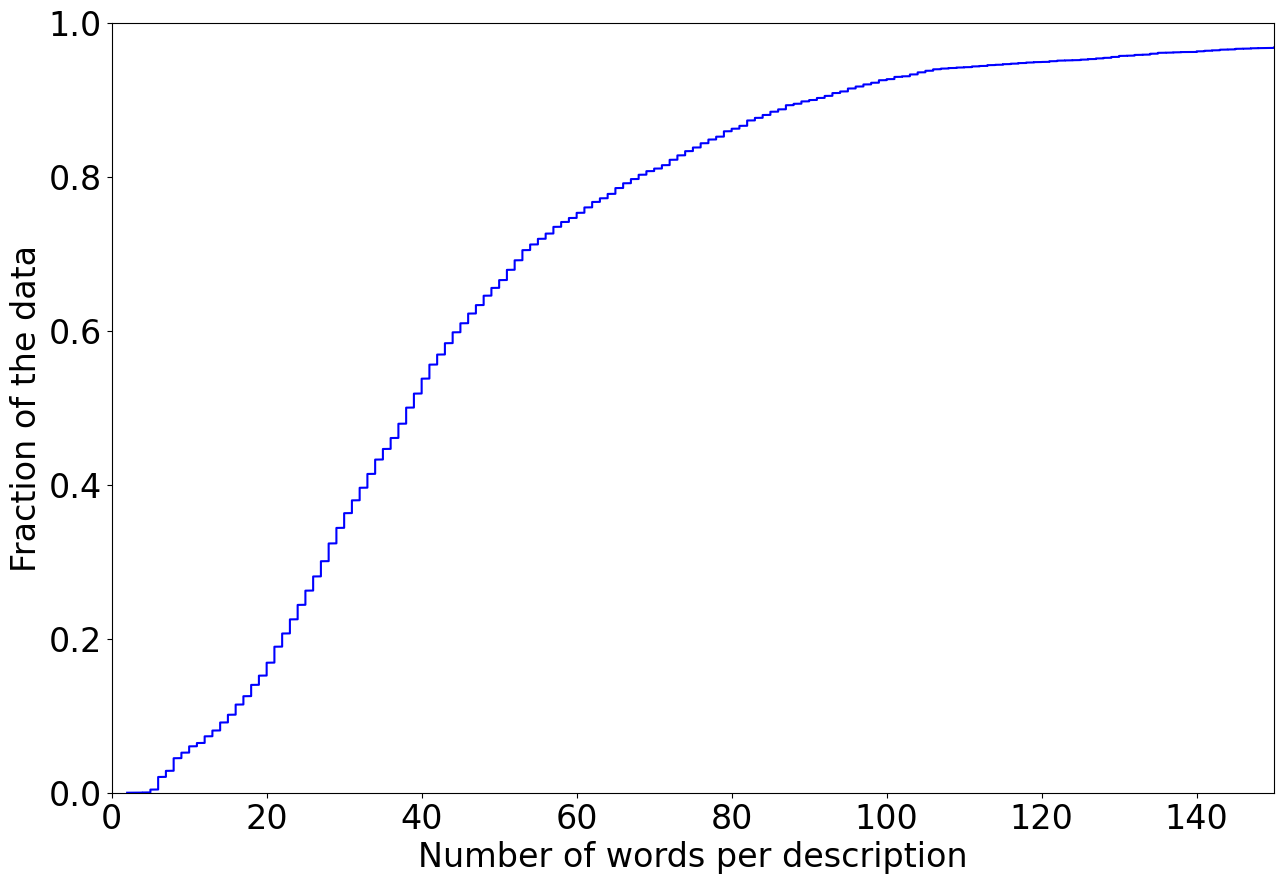

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(desc_len_sorted[:], samples[:], color='blue')
#plt.hlines(0.9, 0, 42, colors='r', linestyles='solid')
#plt.vlines(42, 0, 0.9, colors='r', linestyles='solid')
plt.axis([0, 150, 0, 1])
plt.xlabel('Number of words per description', fontsize=24)
plt.ylabel('Fraction of the data', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
#plt.savefig('', bbox_inches = 'tight')
plt.show()

In [6]:
pd.set_option('display.max_colwidth', None)

#discard samples with a "Description" field containing less than 10 words

#long_enough_description = data.loc[data['Description'].str.split().apply(len) >= 10]
#long_enough_description.reset_index(drop=True, inplace=True)
#long_enough_description.info()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177740 entries, 0 to 177739
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   english_description   177740 non-null  object
 1   cvssv3_attack_vector  177740 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [9]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, [0]]
y = data.iloc[:, [1]]
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(177740, 1)
(177740, 1)
(142192, 1)
(35548, 1)
(142192, 1)
(35548, 1)


In [12]:
X_train.to_csv('./cvss_2022_2024_X_train.csv', index=False)
y_train.to_csv('./cvss_2022_2024_y_train.csv', index=False)

X_test.to_csv('./cvss_2022_2024_X_test.csv', index=False)
y_test.to_csv('./cvss_2022_2024_y_test.csv', index=False)

In [14]:
import pandas as pd

X_train = pd.read_csv('./cvss_2022_2024_X_train.csv')
y_train = pd.read_csv('./cvss_2022_2024_y_train.csv')

X_test = pd.read_csv('./cvss_2022_2024_X_test.csv')
y_test = pd.read_csv('./cvss_2022_2024_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(142192, 1)
(35548, 1)
(142192, 1)
(35548, 1)


In [15]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142192 entries, 0 to 142191
Data columns (total 1 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   cvssv3_attack_vector  142192 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [17]:
for col_name in list(y_train.columns.values[0:8]):
    print("-----------------", col_name, "------------------------")
    print( y_train[col_name].value_counts(dropna=False) )
    print("")
    print( y_test[col_name].value_counts(dropna=False) )
    print("\n")

----------------- cvssv3_attack_vector ------------------------
cvssv3_attack_vector
ADJACENT_NETWORK    35580
NETWORK             35559
PHYSICAL            35532
LOCAL               35521
Name: count, dtype: int64

cvssv3_attack_vector
LOCAL               8914
PHYSICAL            8903
NETWORK             8876
ADJACENT_NETWORK    8855
Name: count, dtype: int64




C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_44044\3051456904.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df_train, x='cvssv3_attack_vector', ax=ax1, palette='viridis')
C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_44044\3051456904.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df_test, x='cvssv3_attack_vector', ax=ax2, palette='viridis')


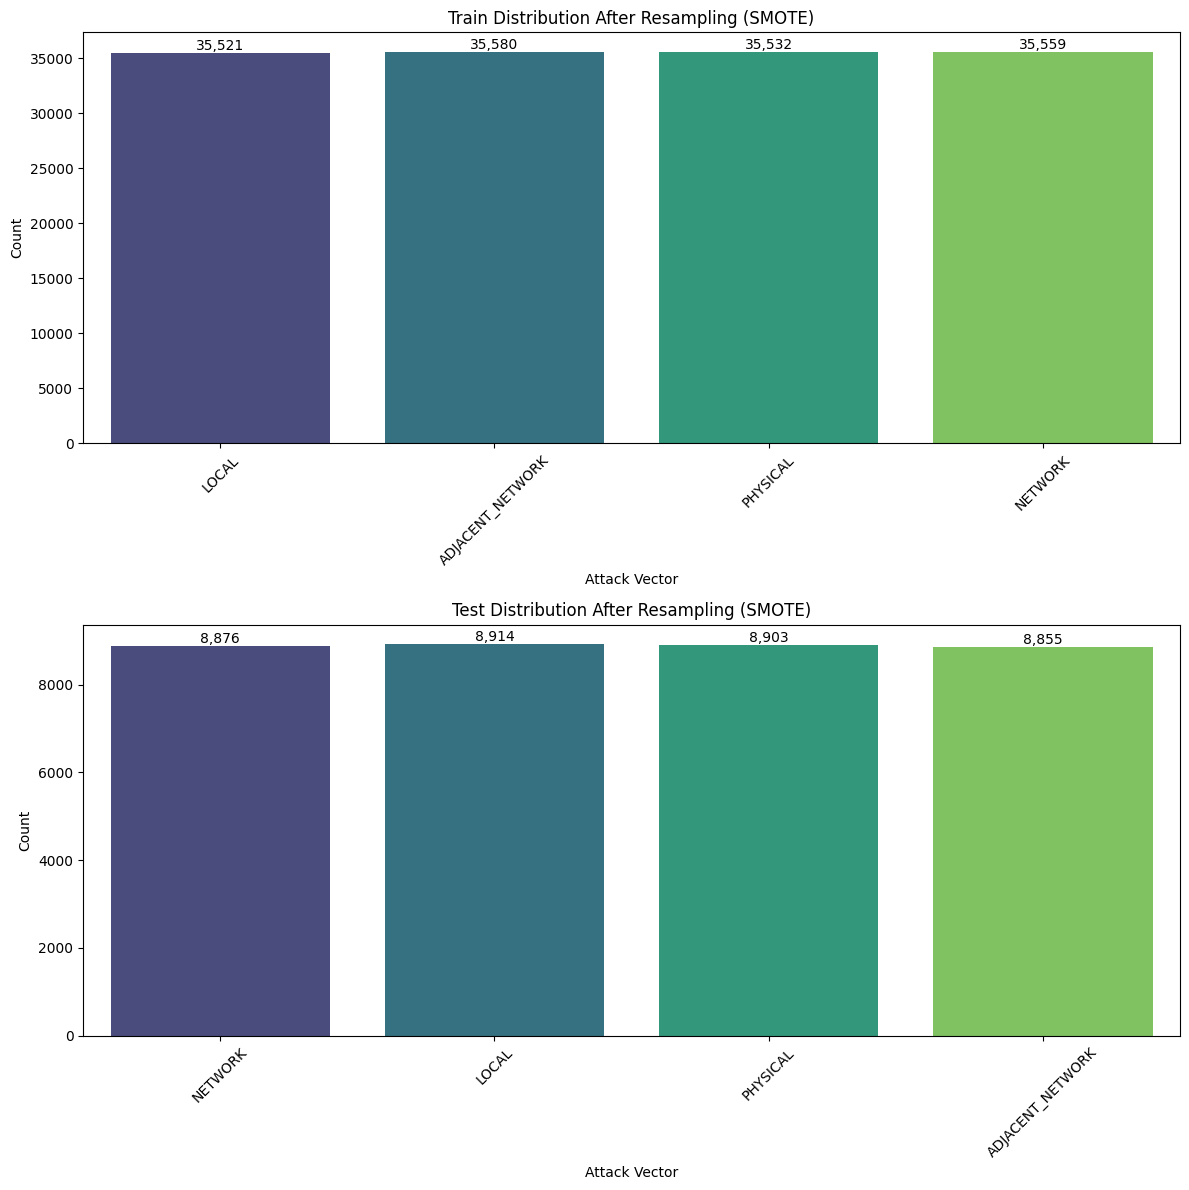

Train Distribution:
cvssv3_attack_vector
ADJACENT_NETWORK    35580
NETWORK             35559
PHYSICAL            35532
LOCAL               35521
Name: count, dtype: int64

Test Distribution:
cvssv3_attack_vector
LOCAL               8914
PHYSICAL            8903
NETWORK             8876
ADJACENT_NETWORK    8855
Name: count, dtype: int64


In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read balanced data train and test
balanced_df_train = pd.read_csv('./cvss_2022_2024_y_train.csv')
balanced_df_test = pd.read_csv('./cvss_2022_2024_y_test.csv')

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot train distribution
sns.countplot(data=balanced_df_train, x='cvssv3_attack_vector', ax=ax1, palette='viridis')
ax1.set_title('Train Distribution After Resampling (SMOTE)')
ax1.set_xlabel('Attack Vector')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars for train data
for p in ax1.patches:
    ax1.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

# Plot test distribution
sns.countplot(data=balanced_df_test, x='cvssv3_attack_vector', ax=ax2, palette='viridis')
ax2.set_title('Test Distribution After Resampling (SMOTE)')
ax2.set_xlabel('Attack Vector')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars for test data
for p in ax2.patches:
    ax2.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

plt.tight_layout()
plt.show()

# Print the exact counts for train and test data
print("Train Distribution:")
print(balanced_df_train['cvssv3_attack_vector'].value_counts())

print("\nTest Distribution:")
print(balanced_df_test['cvssv3_attack_vector'].value_counts())


KESIMPULAN: DATA TELAH BALANCED, BAIK ITU TRAIN MAUPUN TEST